# ResNet Ablation Study
**Dataset:** OxfordIIITPet (binary-category)  
**Reference:** Deep Residual Learning for Image Recognition (He et al., 2015)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

## 1. Block 정의
- **BasicBlock**: ResNet-18, ResNet-34에서 사용 (3×3 conv 2개)
- **BottleneckBlock**: ResNet-50, 101, 152에서 사용 (1×1, 3×3, 1×1 conv)
- **PlainBasicBlock**: Abation Study with ResNet-34
- **PlainBottleneckBlock**: Ablation Study with ResNet-50

In [2]:
class BasicBlock(nn.Module):
    """
    ResNet Basic Block (for ResNet-18, 34)
    
    Structure:
        x → [3×3 conv → BN → ReLU → 3×3 conv → BN] + shortcut(x) → ReLU → out
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        # Main path: F(x)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut path (identity or projection)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        # F(x) path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Shortcut
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # H(x) = F(x) + x
        out += identity
        out = self.relu(out)
        
        return out


class BottleneckBlock(nn.Module):
    """
    ResNet Bottleneck Block (for ResNet-50, 101, 152)
    
    Structure:
        x → [1×1 conv → BN → ReLU → 3×3 conv → BN → ReLU → 1×1 conv → BN] + shortcut(x) → ReLU → out
    
    Note: Output channels = out_channels * expansion (expansion=4)
    """
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        # 1×1 conv: reduce channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3×3 conv: spatial processing
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1×1 conv: expand channels
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, 
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        # F(x) path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Shortcut
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # H(x) = F(x) + x
        out += identity
        out = self.relu(out)
        
        return out

In [3]:
class PlainBasicBlock(nn.Module):
    """
    PlainNet Basic Block (for Ablation Study with ResNet-34)
    
    Structure:
        x → [3×3 conv → BN → ReLU → 3×3 conv → BN] → ReLU → out
    """
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        # Main path: F(x)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Shortcut path (identity or projection)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        # F(x) path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Shortcut
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.relu(out)
        
        return out

class PlainBottleneckBlock(nn.Module):
    """
    PlainNet Bottleneck Block (for Ablation Study with ResNet-50)
    
    Structure:
        x → [1×1 conv → BN → ReLU → 3×3 conv → BN → ReLU → 1×1 conv → BN] → ReLU → out
    
    Note: Output channels = out_channels * expansion (expansion=4)
    """
    expansion = 4
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        
        # 1×1 conv: reduce channels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        # 3×3 conv: spatial processing
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 1×1 conv: expand channels
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, 
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        # F(x) path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        
        out = self.conv3(out)
        out = self.bn3(out)
        
        # Shortcut
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out = self.relu(out)
        
        return out

## 2. ResNet & PlainNet 모델 정의

In [4]:
class ResNet(nn.Module):
    """
    ResNet Architecture
    
    Structure:
        conv1 (7×7, stride=2) → BN → ReLU → MaxPool (3×3, stride=2)
        → layer1 → layer2 → layer3 → layer4
        → AdaptiveAvgPool → FC
    """
    
    def __init__(self, block, num_blocks, num_classes=1000):
        """
        Args:
            block: BasicBlock or BottleneckBlock
            num_blocks: list of 4 integers (blocks per layer)
            num_classes: number of output classes
        """
        super().__init__()
        self.in_channels = 64
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Create a residual layer with multiple blocks.
        
        Args:
            block: block type (BasicBlock or BottleneckBlock)
            out_channels: base output channels (before expansion)
            num_blocks: number of blocks in this layer
            stride: stride for the first block (for downsampling)
        """
        downsample = None
        
        # Downsample if spatial size changes or channel mismatch
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        
        layers = []
        # First block (may have stride > 1 and downsample)
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        
        # Remaining blocks (stride=1, no downsample)
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial conv
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

def resnet18(num_classes=1000): return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)
def resnet34(num_classes=1000): return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)
def resnet50(num_classes=1000): return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)
def resnet101(num_classes=1000): return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)
def resnet152(num_classes=1000): return ResNet(BottleneckBlock, [3, 8, 36, 3], num_classes)

In [5]:
class PlainNet(nn.Module):
    """
    PlainNet Architecture (for Ablation Study)
    
    Structure:
        conv1 (7×7, stride=2) → BN → ReLU → MaxPool (3×3, stride=2)
        → layer1 → layer2 → layer3 → layer4
        → AdaptiveAvgPool → FC
    """
    
    def __init__(self, block, num_blocks, num_classes=1000):
        """
        Args:
            block: PlainBasicBlock or PlainBottleneckBlock
            num_blocks: list of 4 integers (blocks per layer)
            num_classes: number of output classes
        """
        super().__init__()
        self.in_channels = 64
        
        # Initial convolution
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        # Residual layers
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
    
    def _make_layer(self, block, out_channels, num_blocks, stride):
        """
        Create a non-residual layer with multiple blocks.
        
        Args:
            block: block type (PlainBasicBlock or PlainBottleneckBlock)
            out_channels: base output channels (before expansion)
            num_blocks: number of blocks in this layer
            stride: stride for the first block
        """
        downsample = None
        
        # Downsample if spatial size changes or channel mismatch
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )
        
        layers = []
        # First block (may have stride > 1 and downsample)
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        
        # Remaining blocks (stride=1, no downsample)
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        # Initial conv
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        # Residual layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        # Classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

def plainnet18(num_classes=1000): return PlainNet(PlainBasicBlock, [2, 2, 2, 2], num_classes)
def plainnet34(num_classes=1000): return PlainNet(PlainBasicBlock, [3, 4, 6, 3], num_classes)
def plainnet50(num_classes=1000): return PlainNet(PlainBottleneckBlock, [3, 4, 6, 3], num_classes)
def plainnet101(num_classes=1000): return PlainNet(PlainBottleneckBlock, [3, 4, 23, 3], num_classes)
def plainnet152(num_classes=1000): return PlainNet(PlainBottleneckBlock, [3, 8, 36, 3], num_classes)

## 3. 모델 구조 확인

In [6]:
# 모델 생성 및 파라미터 수 확인
model = resnet34(num_classes=1000)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: ResNet-34")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Forward pass test
test_input = torch.randn(1, 3, 224, 224)
test_output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")

Model: ResNet-34
Total parameters: 21,797,672
Trainable parameters: 21,797,672
Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1000])


In [7]:
# 모델 생성 및 파라미터 수 확인
model = resnet50(num_classes=1000)

# 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: ResNet-50")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# Forward pass test
test_input = torch.randn(1, 3, 224, 224)
test_output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")

Model: ResNet-50
Total parameters: 25,557,032
Trainable parameters: 25,557,032
Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1000])


## 4. 데이터셋 준비

In [ ]:
# Data transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# Load datasets
trainset = torchvision.datasets.OxfordIIITPet(root='./data', split='trainval', target_types=["binary-category","category"], transform=train_transform, download=True)
testset = torchvision.datasets.OxfordIIITPet(root='./data', split='test', target_types=["binary-category","category"], transform=test_transform, download=True)

# DataLoaders
OxfordIIITPet_trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
OxfordIIITPet_testloader = DataLoader(testset, batch_size=32, shuffle=False)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"First Data Label: {trainset[0][1][0]}")  # binary-category

100%|██████████| 792M/792M [00:53<00:00, 14.9MB/s]  
100%|██████████| 19.2M/19.2M [00:02<00:00, 7.62MB/s]


Training samples: 3680
Test samples: 3669
First Data Label: 0


In [ ]:
# Load datasets
trainset = torchvision.datasets.Imagenette(root='./data', split='train', transform=train_transform, download=True)
testset = torchvision.datasets.Imagenette(root='./data', split='val', transform=test_transform, download=True)

# DataLoaders
Imagenette_trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
Imagenette_testloader = DataLoader(testset, batch_size=32, shuffle=False)

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"First Data Label: {trainset[0][1]}")  # binary-category

## 5. 학습 준비

In [ ]:
train_losses_resnet34 = []
train_accuracies_resnet34 = []
test_losses_resnet34 = []
test_accuracies_resnet34 = []

train_losses_plainnet34 = []
train_accuracies_plainnet34 = []
test_losses_plainnet34 = []
test_accuracies_plainnet34 = []

train_losses_resnet50 = []
train_accuracies_resnet50 = []
test_losses_resnet50 = []
test_accuracies_resnet50 = []

train_losses_plainnet50 = []
train_accuracies_plainnet50 = []
test_losses_plainnet50 = []
test_accuracies_plainnet50 = []

In [ ]:
def Implementation(num_epochs, model, trainloader, testloader, lr):
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Define loss function, optimizer, and scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr, momentum=0.9, weight_decay=1e-4)

    # Initialize lists to store losses and accuracies
    train_losses_resnet34 = []
    train_accuracies_resnet34 = []
    test_losses_resnet34 = []
    test_accuracies_resnet34 = []

    start_time = time.time()

    for epoch in range(num_epochs):
        # ================ Train ================
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in trainloader:
            images, labels = images.to(device), labels[0].to(device)

            # [Training Process]
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Trainset의 Loss 누적 및 정확도 계산
            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        # Calculate average training loss and accuracy
        epoch_train_loss = train_loss / len(trainset)
        train_losses_resnet34.append(epoch_train_loss)
        train_accuracy = 100.0 * train_correct / train_total
        train_accuracies_resnet34.append(train_accuracy)
        
        # ================ Test ================
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels[0].to(device)

                # [Testing Process]
                outputs = model(images)

                # Testset의 Loss 누적 및 정확도 계산
                test_loss += criterion(outputs, labels).item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        # Calculate average test loss and accuracy
        epoch_test_loss = test_loss / len(testset)
        test_losses_resnet34.append(epoch_test_loss)
        test_accuracy = 100.0 * test_correct / test_total
        test_accuracies_resnet34.append(test_accuracy)


        print(f"Epoch [{epoch+1}/{num_epochs}]")
        print(f" - Train_Loss: {epoch_train_loss:6.4f}, Train_Accuracy: {train_accuracy:4.2f}%")
        print(f" - Test_Loss: {epoch_test_loss:6.4f}, Test_Accuracy: {test_accuracy:4.2f}%")
        print("-" * 60)

    elapsed = time.time() - start_time
    print(f"\nTraining completed in {elapsed/60:.1f} minutes")
    print(f"Best accuracy: {max(test_accuracies_resnet34):.2f}%")

    return (train_losses_resnet34, train_accuracies_resnet34, test_losses_resnet34, test_accuracies_resnet34)

In [ ]:
model1 = resnet34(num_classes=2).to(device) # Oxford-IIIT Pet has 2 classes (cat, dog)
model2 = plainnet34(num_classes=2).to(device) # Oxford-IIIT Pet has 2 classes (cat, dog)
model3 = resnet50(num_classes=2).to(device) # Oxford-IIIT Pet has 2 classes (cat, dog)
model4 = plainnet50(num_classes=2).to(device) # Oxford-IIIT Pet
model5 = resnet34(num_classes=10).to(device) # Imagenette has 10 classes
model6 = plainnet34(num_classes=10).to(device) # Imagenette has 10 classes
model7 = resnet50(num_classes=10).to(device) # Imagenette has 10 classes
model8 = plainnet50(num_classes=10).to(device) # Imagenette has 10 classes

num_epochs = 15
lr = 0.01

## 6. 학습 및 평가결과 시각화

In [ ]:
train_losses_resnet34, train_accuracies_resnet34, test_losses_resnet34, test_accuracies_resnet34 = Implementation(num_epochs, model1, OxfordIIITPet_trainloader, OxfordIIITPet_testloader, lr)
train_losses_plainnet34, train_accuracies_plainnet34, test_losses_plainnet34, test_accuracies_plainnet34 = Implementation(num_epochs, model2, OxfordIIITPet_trainloader, OxfordIIITPet_testloader, lr)
train_losses_resnet50, train_accuracies_resnet50, test_losses_resnet50, test_accuracies_resnet50 = Implementation(num_epochs, model3, OxfordIIITPet_trainloader, OxfordIIITPet_testloader, lr)
train_losses_plainnet50, train_accuracies_plainnet50, test_losses_plainnet50, test_accuracies_plainnet50 = Implementation(num_epochs, model4, OxfordIIITPet_trainloader, OxfordIIITPet_testloader, lr)

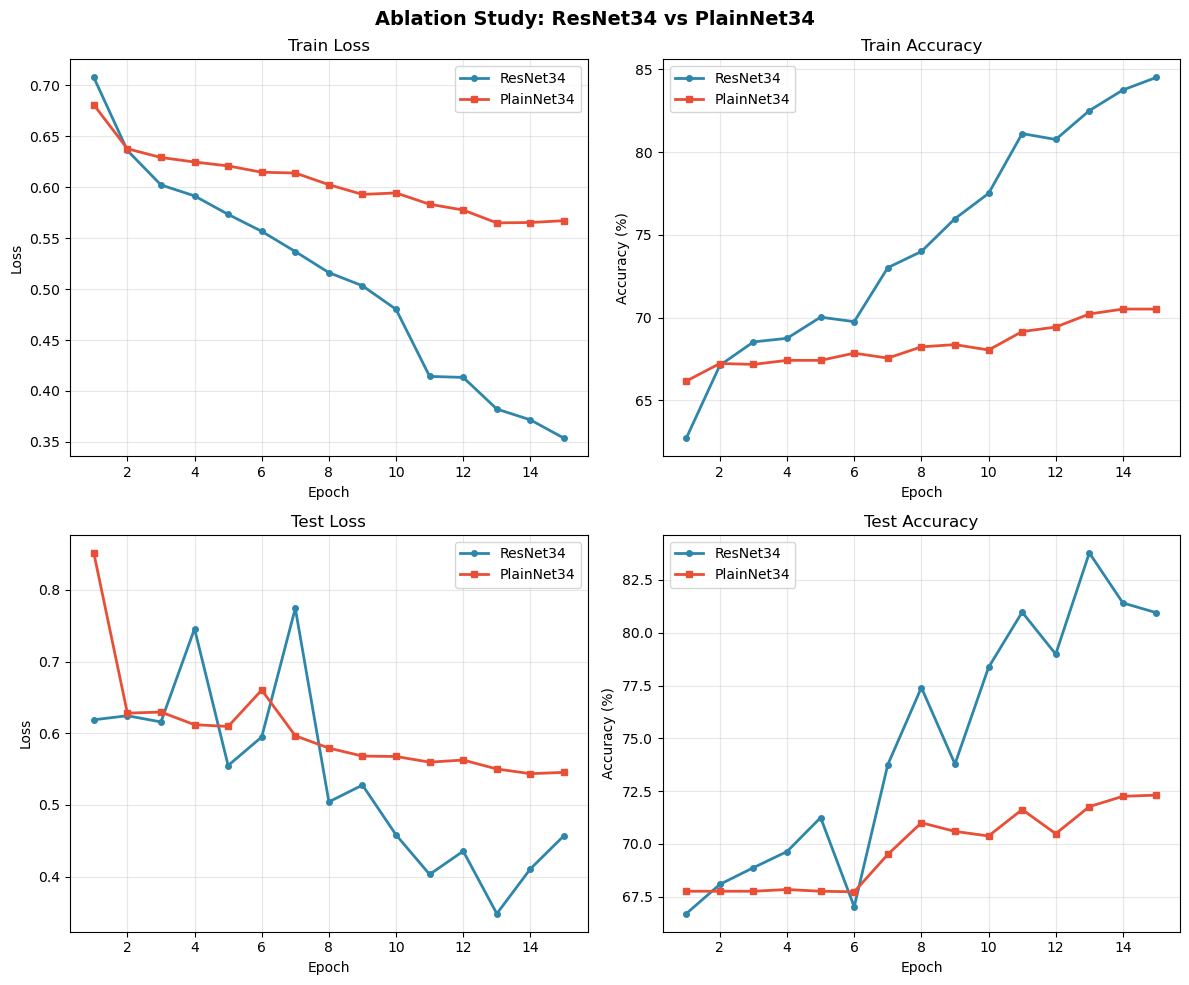

Ablation Study Final Results
Model           Train Loss   Train Acc    Test Loss    Test Acc    
----------------------------------------------------------------------
ResNet34         0.3537       84.51        0.4572       80.95       
PlainNet34       0.5672       70.52        0.5455       72.31       

Residual Connection Effect on Test Accuracy: +8.64%


In [ ]:
# Ablation Study Result Visualization
# ResNet34 vs PlainNet34 비교

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

epochs = range(1, len(train_losses_resnet34) + 1)

# 색상 설정
resnet_color = '#2E86AB'    # 파란색 계열
plainnet_color = '#E94F37'  # 빨간색 계열

# (0, 0) Train Loss
axes[0, 0].plot(epochs, train_losses_resnet34, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet34')
axes[0, 0].plot(epochs, train_losses_plainnet34, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet34')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Train Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# (0, 1) Train Accuracy
axes[0, 1].plot(epochs, train_accuracies_resnet34, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet34')
axes[0, 1].plot(epochs, train_accuracies_plainnet34, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet34')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Train Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# (1, 0) Validation Loss
axes[1, 0].plot(epochs, test_losses_resnet34, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet34')
axes[1, 0].plot(epochs, test_losses_plainnet34, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet34')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Test Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# (1, 1) Validation Accuracy
axes[1, 1].plot(epochs, test_accuracies_resnet34, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet34')
axes[1, 1].plot(epochs, test_accuracies_plainnet34, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet34')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 전체 제목
fig.suptitle('Ablation Study: ResNet34 vs PlainNet34', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ablation_study_result.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# 최종 결과 요약 출력
# ============================================================

print("=" * 70)
print("Ablation Study Final Results")
print("=" * 70)
print(f"{'Model':<15} {'Train Loss':<12} {'Train Acc':<12} {'Test Loss':<12} {'Test Acc':<12}")
print("-" * 70)
print(f"{'ResNet34':<16} {train_losses_resnet34[-1]:<12.4f} {train_accuracies_resnet34[-1]:<12.2f} {test_losses_resnet34[-1]:<12.4f} {test_accuracies_resnet34[-1]:<12.2f}")
print(f"{'PlainNet34':<16} {train_losses_plainnet34[-1]:<12.4f} {train_accuracies_plainnet34[-1]:<12.2f} {test_losses_plainnet34[-1]:<12.4f} {test_accuracies_plainnet34[-1]:<12.2f}")
print("=" * 70)
print(f"\nResidual Connection Effect on Test Accuracy: {test_accuracies_resnet34[-1] - test_accuracies_plainnet34[-1]:+.2f}%")

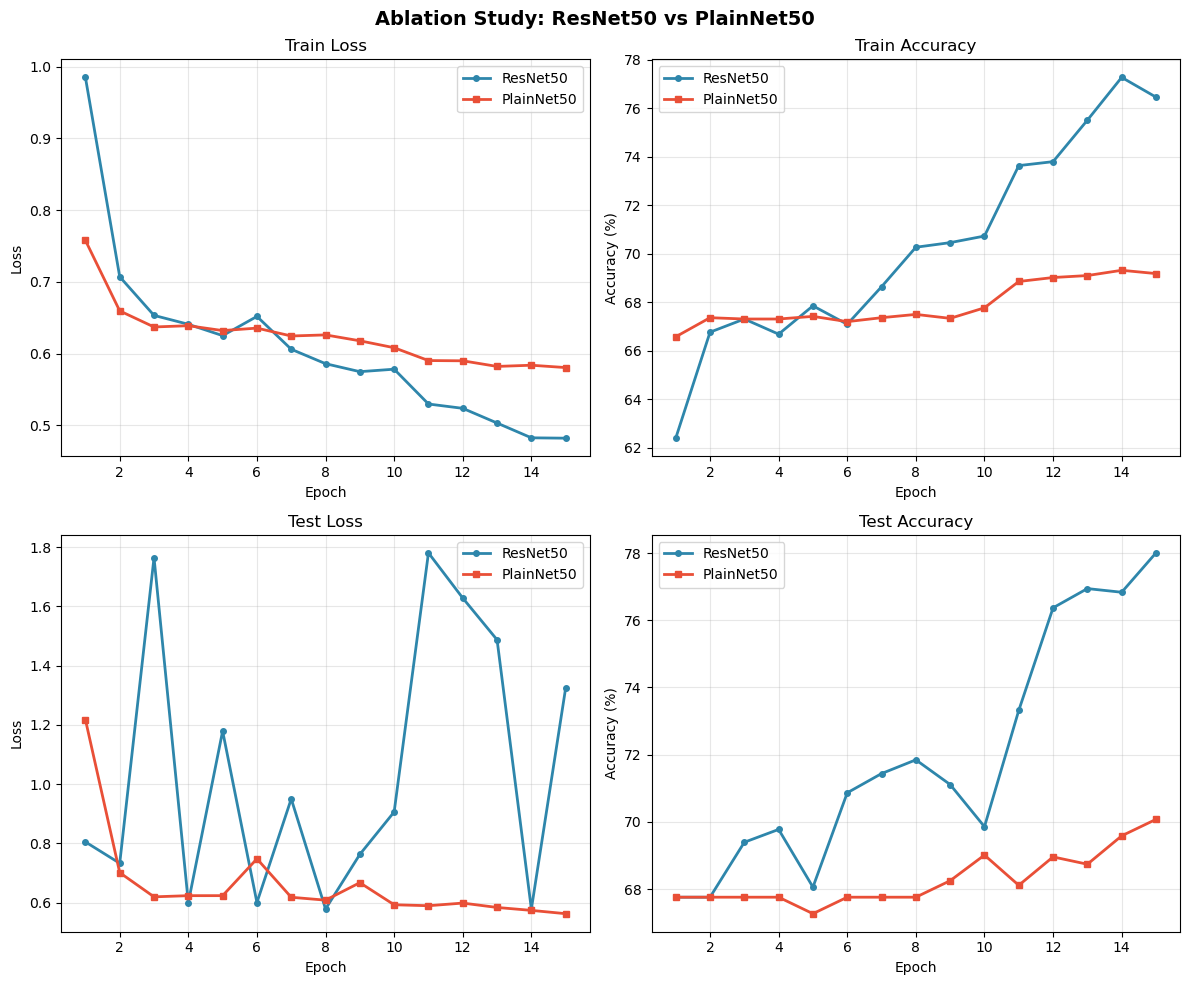

Ablation Study Final Results
Model           Train Loss   Train Acc    Test Loss    Test Acc    
----------------------------------------------------------------------
ResNet50         0.4820       76.47        1.3248       78.00       
PlainNet50       0.5804       69.18        0.5627       70.07       

Residual Connection Effect on Test Accuracy: +7.93%


In [ ]:
# Ablation Study Result Visualization
# ResNet50 vs PlainNet50 비교

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

epochs = range(1, len(train_losses_resnet50) + 1)
# 색상 설정
resnet_color = '#2E86AB'    # 파란색 계열
plainnet_color = '#E94F37'  # 빨간색 계열

# (0, 0) Train Loss
axes[0, 0].plot(epochs, train_losses_resnet50, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet50')
axes[0, 0].plot(epochs, train_losses_plainnet50, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet50')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Train Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# (0, 1) Train Accuracy
axes[0, 1].plot(epochs, train_accuracies_resnet50, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet50')
axes[0, 1].plot(epochs, train_accuracies_plainnet50, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet50')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Train Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# (1, 0) Validation Loss
axes[1, 0].plot(epochs, test_losses_resnet50, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet50')
axes[1, 0].plot(epochs, test_losses_plainnet50, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet50')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Test Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# (1, 1) Validation Accuracy
axes[1, 1].plot(epochs, test_accuracies_resnet50, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet50')
axes[1, 1].plot(epochs, test_accuracies_plainnet50, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet50')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 전체 제목
fig.suptitle('Ablation Study: ResNet50 vs PlainNet50', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ablation_study_result.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# 최종 결과 요약 출력
# ============================================================

print("=" * 70)
print("Ablation Study Final Results")
print("=" * 70)
print(f"{'Model':<15} {'Train Loss':<12} {'Train Acc':<12} {'Test Loss':<12} {'Test Acc':<12}")
print("-" * 70)
print(f"{'ResNet50':<16} {train_losses_resnet50[-1]:<12.4f} {train_accuracies_resnet50[-1]:<12.2f} {test_losses_resnet50[-1]:<12.4f} {test_accuracies_resnet50[-1]:<12.2f}")
print(f"{'PlainNet50':<16} {train_losses_plainnet50[-1]:<12.4f} {train_accuracies_plainnet50[-1]:<12.2f} {test_losses_plainnet50[-1]:<12.4f} {test_accuracies_plainnet50[-1]:<12.2f}")
print("=" * 70)
print(f"\nResidual Connection Effect on Test Accuracy: {test_accuracies_resnet50[-1] - test_accuracies_plainnet50[-1]:+.2f}%")

In [ ]:
train_losses_resnet34_img, train_accuracies_resnet34_img, test_losses_resnet34_img, test_accuracies_resnet34_img = Implementation(num_epochs, model5, Imagenette_trainloader, Imagenette_testloader, lr)
train_losses_plainnet34_img, train_accuracies_plainnet34_img, test_losses_plainnet34_img, test_accuracies_plainnet34_img = Implementation(num_epochs, model6, Imagenette_trainloader, Imagenette_testloader, lr)
train_losses_resnet50_img, train_accuracies_resnet50_img, test_losses_resnet50_img, test_accuracies_resnet50_img = Implementation(num_epochs, model7, Imagenette_trainloader, Imagenette_testloader, lr)
train_losses_plainnet50_img, train_accuracies_plainnet50_img, test_losses_plainnet50_img, test_accuracies_plainnet50_img = Implementation(num_epochs, model8, Imagenette_trainloader, Imagenette_testloader, lr)

In [ ]:
# Ablation Study Result Visualization
# ResNet34 vs PlainNet34 비교

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

epochs = range(1, len(train_losses_resnet34) + 1)

# 색상 설정
resnet_color = '#2E86AB'    # 파란색 계열
plainnet_color = '#E94F37'  # 빨간색 계열

# (0, 0) Train Loss
axes[0, 0].plot(epochs, train_losses_resnet34, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet34')
axes[0, 0].plot(epochs, train_losses_plainnet34, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet34')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Train Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# (0, 1) Train Accuracy
axes[0, 1].plot(epochs, train_accuracies_resnet34, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet34')
axes[0, 1].plot(epochs, train_accuracies_plainnet34, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet34')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Train Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# (1, 0) Validation Loss
axes[1, 0].plot(epochs, test_losses_resnet34, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet34')
axes[1, 0].plot(epochs, test_losses_plainnet34, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet34')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Test Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# (1, 1) Validation Accuracy
axes[1, 1].plot(epochs, test_accuracies_resnet34, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet34')
axes[1, 1].plot(epochs, test_accuracies_plainnet34, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet34')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 전체 제목
fig.suptitle('Ablation Study: ResNet34 vs PlainNet34', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ablation_study_result.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# 최종 결과 요약 출력
# ============================================================

print("=" * 70)
print("Ablation Study Final Results")
print("=" * 70)
print(f"{'Model':<15} {'Train Loss':<12} {'Train Acc':<12} {'Test Loss':<12} {'Test Acc':<12}")
print("-" * 70)
print(f"{'ResNet34':<16} {train_losses_resnet34[-1]:<12.4f} {train_accuracies_resnet34[-1]:<12.2f} {test_losses_resnet34[-1]:<12.4f} {test_accuracies_resnet34[-1]:<12.2f}")
print(f"{'PlainNet34':<16} {train_losses_plainnet34[-1]:<12.4f} {train_accuracies_plainnet34[-1]:<12.2f} {test_losses_plainnet34[-1]:<12.4f} {test_accuracies_plainnet34[-1]:<12.2f}")
print("=" * 70)
print(f"\nResidual Connection Effect on Test Accuracy: {test_accuracies_resnet34[-1] - test_accuracies_plainnet34[-1]:+.2f}%")

In [ ]:
# Ablation Study Result Visualization
# ResNet50 vs PlainNet50 비교

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

epochs = range(1, len(train_losses_resnet50) + 1)
# 색상 설정
resnet_color = '#2E86AB'    # 파란색 계열
plainnet_color = '#E94F37'  # 빨간색 계열

# (0, 0) Train Loss
axes[0, 0].plot(epochs, train_losses_resnet50, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet50')
axes[0, 0].plot(epochs, train_losses_plainnet50, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet50')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Train Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# (0, 1) Train Accuracy
axes[0, 1].plot(epochs, train_accuracies_resnet50, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet50')
axes[0, 1].plot(epochs, train_accuracies_plainnet50, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet50')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Train Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# (1, 0) Validation Loss
axes[1, 0].plot(epochs, test_losses_resnet50, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet50')
axes[1, 0].plot(epochs, test_losses_plainnet50, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet50')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Test Loss')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# (1, 1) Validation Accuracy
axes[1, 1].plot(epochs, test_accuracies_resnet50, color=resnet_color, 
                linewidth=2, marker='o', markersize=4, label='ResNet50')
axes[1, 1].plot(epochs, test_accuracies_plainnet50, color=plainnet_color, 
                linewidth=2, marker='s', markersize=4, label='PlainNet50')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 전체 제목
fig.suptitle('Ablation Study: ResNet50 vs PlainNet50', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('ablation_study_result.png', dpi=150, bbox_inches='tight')
plt.show()

# ============================================================
# 최종 결과 요약 출력
# ============================================================

print("=" * 70)
print("Ablation Study Final Results")
print("=" * 70)
print(f"{'Model':<15} {'Train Loss':<12} {'Train Acc':<12} {'Test Loss':<12} {'Test Acc':<12}")
print("-" * 70)
print(f"{'ResNet50':<16} {train_losses_resnet50[-1]:<12.4f} {train_accuracies_resnet50[-1]:<12.2f} {test_losses_resnet50[-1]:<12.4f} {test_accuracies_resnet50[-1]:<12.2f}")
print(f"{'PlainNet50':<16} {train_losses_plainnet50[-1]:<12.4f} {train_accuracies_plainnet50[-1]:<12.2f} {test_losses_plainnet50[-1]:<12.4f} {test_accuracies_plainnet50[-1]:<12.2f}")
print("=" * 70)
print(f"\nResidual Connection Effect on Test Accuracy: {test_accuracies_resnet50[-1] - test_accuracies_plainnet50[-1]:+.2f}%")

## 7. 회고
- 디테일하게 모든 줄을 꼼꼼하게 살펴보지 않았었고, 구체적으로 라이브러리 사용법을 많이 알아둔 게 아니었는데 이번 학습을 통해 그런 부분에서 많이 배운 것 같다. 
- 결과가 제대로 나오는 게 중요하다는 건 알지만, 그렇다고 일부러 여러 번 시도하여 가장 좋은 결과를 시각화하고 싶지는 않았기에 하이퍼파라미터나 데이터셋 측면에서 여러 시도를 해보려 했다. 
- 어려운 문제일수록, 클래스가 많을수록, 학습데이터셋이 부족할수록 진행이 어려워진다는 걸 더 체감할 수 있었고, 어떻게 하면 가장 적은 자원으로 좋은 성능을 보일 수 있을지 연구해볼 수 있어 좋았다. 
- 노드를 학습하며 중간중간 논문을 더 깊이 읽어보려고 했었는데, 그게 프로젝트를 진행하며 성능저하를 만날 때 도움이 되었던 것 같다. 